# Machine Learning Foundation

## Course 5, Part h: Autoencoders LAB

## Learning Objectives 

1. Implement the following dimensionality reduction techniques on the MNIST data:
    * PCA
    * Autoencoders
    * Variational autoencoders
2. Use appropriate scoring metrics to compare the performance of each.

## MNIST data

Throughout this lesson, we'll be working with the famous [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database), which contains 70,000 handwritten black-and-white images, which are traditionally split into 60k training images and 10k validation images.

In [43]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
np.set_printoptions(precision=2)

import matplotlib.pyplot as plt
import os

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

### Preprocess MNIST
**We'll preprocess by scaling images pixels to be between 0 and 1.**

In [3]:
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

### Part 1: PCA
- We'll use PCA as a baseline with which we can compare our deep learning models.
- **For PCA we'll treat each image like a "row" of data and flatten our data, so each observation is 784 columns:**

In [4]:
x_train_flat = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_flat = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(f"Flattened x_train shape: {x_train_flat.shape}")
print(f"Flattened x_test shape: {x_test_flat.shape}")

Flattened x_train shape: (60000, 784)
Flattened x_test shape: (10000, 784)


Recall that PCA will do a **matrix decomposition** of this data to find the **eigenvalues** - these **eigenvalues** will be the **principal components** of the data, or the "latent features" that describe a maximal amount of variance in the data.

**PCA works better if our features are scaled,** so let's do that.

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
s = MinMaxScaler().fit(x_train_flat)
x_train_scaled = s.transform(x_train_flat)

In [7]:
from sklearn.decomposition import PCA

In [8]:
def mnist_pca(x_data, n_components):
    pca = PCA(n_components=n_components)
    fit_pca = pca.fit(x_data)
    print(f"Variance explained with {n_components} components: {round(sum(fit_pca.explained_variance_ratio_), 2)}")
    return fit_pca, fit_pca.transform(x_data)

In [9]:
pca_full, mnist_data_full = mnist_pca(x_train_scaled, 784)

Variance explained with 784 components: 1.0


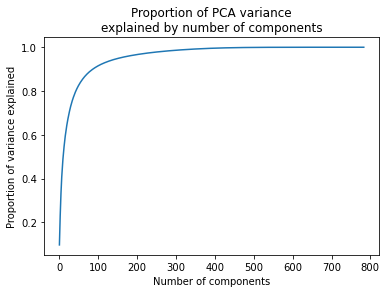

In [10]:
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.title("Proportion of PCA variance\nexplained by number of components")
plt.xlabel("Number of components")
plt.ylabel("Proportion of variance explained")
plt.show()

**We need about 250 components to explain 90% of the variance in the data!**

For visualization purposes, let's extract just two components and plot them:

In [11]:
pca_2, mnist_data_2 = mnist_pca(x_train_scaled, 2)

Variance explained with 2 components: 0.17


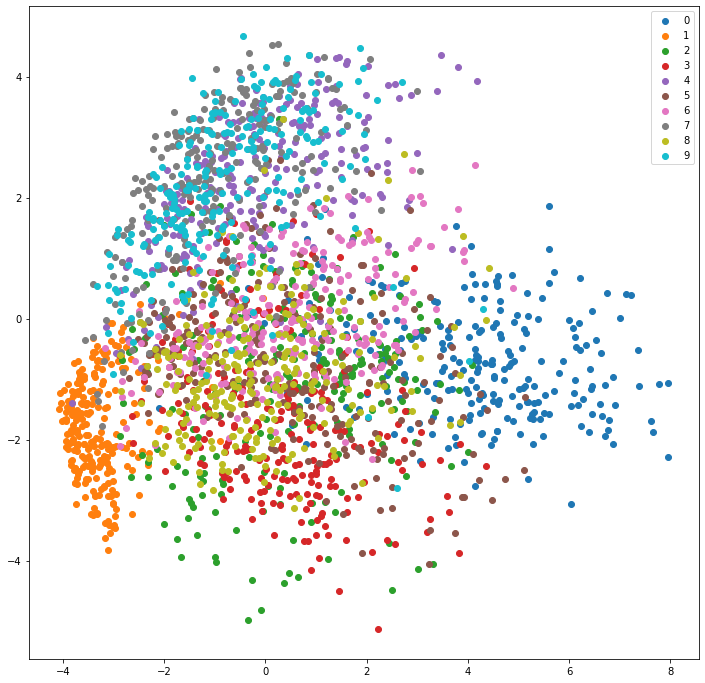

In [12]:
num_images_per_class = 250
fig = plt.figure(figsize=(12, 12))
for number in list(range(10)):
    mask = y_train == number
    x_data = mnist_data_2[mask, 0][:num_images_per_class]
    y_data = mnist_data_2[mask, 1][:num_images_per_class]
    plt.scatter(x_data, y_data, label=number, alpha=1)
plt.legend()
plt.show()

We can already see that the latent features PCA is learning _somewhat_ disentangle the features here, and a neural network could certainly help with this.

### Scoring PCA
What we really care about is: **how good is PCA at creating a low dimensional representation of the MNIST data?**

**As with all models, we should test performance on a different dataset than we trained on:**

In [13]:
pca_64, mnist_data_64 = mnist_pca(x_train_scaled, 64)

Variance explained with 64 components: 0.86


In [14]:
s = MinMaxScaler().fit(x_test_flat)
x_test_scaled = s.transform(x_test_flat)

In [15]:
x_test_flat_64 = pca_64.transform(x_test_scaled)
x_test_reconstructed_64 = pca_64.inverse_transform(x_test_flat_64)

In [16]:
x_test_reconstructed_64.shape

(10000, 784)

In [17]:
true = x_test_scaled
reconstructed = x_test_reconstructed_64

In [18]:
def mse_reconstruction(true, reconstructed):
    return np.sum(np.power(true - reconstructed, 2) / true.shape[1])

In [19]:
mse_reconstruction(true, reconstructed)

90.58529

Average MSE is **90.6**, using 64 components, for PCA.

### Simple Autoencoder
- Now let's build an autoencoder! 
- Fundamentally, **an autoencoder is an neural network where the input is the same as the output.** 
- **The hope for such networks is that one of the hidden layers will "learn a compressed representation" of the data, similar to the way PCA does.**

In practice, when implementing autoencoders using `Keras`, we define _three_ models:

* **The "full autoencoder"**, here `full_model`, **will take inputs and try to reconstruct them.**
* **The "encoder"**, here `encoder_model`, **will take inputs and try to reconstruct them.**
* **The "decoder"**, here `decoder_model`, **will take the latent space and try to reconstruct it.**

In [20]:
encoding_dim = 64

# Encoder model
inputs = tf.keras.Input(shape=(784,))
encoded = tf.keras.layers.Dense(encoding_dim, activation="sigmoid")(inputs)
encoder_model = tf.keras.Model(inputs, encoded, name="encoder")

# Decoder model
encoded_inputs = tf.keras.Input(shape=(encoding_dim,), name="encoding")
reconstruction = tf.keras.layers.Dense(784, activation="sigmoid")(encoded_inputs)
decoder_model = tf.keras.Model(encoded_inputs, reconstruction, name="decoder")

# Defining the full model as the combination of the two
outputs = decoder_model(encoder_model(inputs))
full_model = tf.keras.Model(inputs, outputs, name="full_autoencoder")

In [21]:
full_model = tf.keras.Model(inputs=inputs, outputs=outputs)
opt = tf.keras.optimizers.RMSprop()
full_model.compile(optimizer=opt,
                   loss=tf.keras.losses.BinaryCrossentropy(),
                   metrics=[tf.keras.metrics.BinaryAccuracy()])

In [22]:
history = full_model.fit(x_train_flat, x_train_flat, shuffle=True,
                         epochs=5, batch_size=32)

Epoch 1/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2064 - binary_accuracy: 0.8029A: 1s - loss: 0.24
Epoch 2/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1472 - binary_accuracy: 0.8082
Epoch 3/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1288 - binary_accuracy: 0.8108
Epoch 4/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1186 - binary_accuracy: 0.8120
Epoch 5/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1127 - binary_accuracy: 0.8126


Recall that with Keras, training the model with layers 1-5 trains the smaller model simultaneously, as long as they are built off of the same underlying objects!

In [23]:
full_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
encoder (Functional)         (None, 64)                50240     
_________________________________________________________________
decoder (Functional)         (None, 784)               50960     
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________


In [24]:
encoded_images = encoder_model.predict(x_test_flat)
encoded_images.shape

(10000, 64)

So, the "encoder model" has already been trained! For example, the encoding for the first image in the test dataset is:

In [25]:
encoded_images[0]

array([0.1 , 1.  , 0.01, 1.  , 0.97, 0.79, 0.87, 1.  , 0.69, 0.98, 0.98,
       0.05, 1.  , 0.89, 1.  , 1.  , 1.  , 1.  , 1.  , 0.16, 0.81, 1.  ,
       0.95, 0.16, 1.  , 1.  , 0.35, 0.72, 0.28, 1.  , 0.62, 0.79, 0.04,
       1.  , 1.  , 0.97, 1.  , 0.11, 1.  , 1.  , 1.  , 0.8 , 1.  , 1.  ,
       1.  , 0.54, 0.04, 1.  , 0.17, 0.6 , 0.2 , 0.18, 1.  , 1.  , 0.39,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.55],
      dtype=float32)

As we can see, the `encoder_model` has been trained!

### Exercise 1

With PCA, we compared the pixel-wise difference between the reconstructed images and the original images to score how good the model was. 

Your task is now to do the same using the autoencoder. You'll have to think about what needs to get fed through the autoencoder to do this. Your steps are:

1. Use the trained autoencoder to generate reconstructed images.
2. Compute the pixel-wise distance between the reconstructed images and the original images. 

Is your result higher or lower than what you got with PCA?

In [26]:
# Generate reconstructed images
decoded_images = full_model.predict(x_test_flat)
mse_reconstruction(decoded_images, x_test_flat)

148.20894

### Exercise 2:
Let's add an extra hidden Dense layer to both the `encoder_model` and the `decoder_model`.

In [27]:
encoding_dim = 64
hidden_dim = 256

# Encoder model
inputs = tf.keras.Input(shape=(784,))
encoded = tf.keras.layers.Dense(encoding_dim, activation="relu")(inputs)
encoder_hidden = tf.keras.layers.Dense(hidden_dim, activation="sigmoid")(encoded)
encoder_model = tf.keras.Model(inputs, encoded, name="encoder")

# Decoder model
encoded_inputs = tf.keras.Input(shape=(encoding_dim,), name="encoding")
decoder_hidden = tf.keras.layers.Dense(hidden_dim, activation="relu")(encoded_inputs)
reconstruction = tf.keras.layers.Dense(784, activation="sigmoid")(decoder_hidden)
decoder_model = tf.keras.Model(encoded_inputs, reconstruction, name="decoder")

# Defining the full model as the combination of the two
outputs = decoder_model(encoder_model(inputs))
full_model = tf.keras.Model(inputs, outputs, name="full_ae")

In [28]:
full_model = tf.keras.Model(inputs=inputs, outputs=outputs)

full_model.compile(optimizer=opt,
                   loss=tf.keras.losses.BinaryCrossentropy(),
                   metrics=[tf.keras.metrics.BinaryAccuracy()])

In [29]:
history = full_model.fit(x_train_flat, x_train_flat, shuffle=True, epochs=2, batch_size=32)

Epoch 1/2
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1187 - binary_accuracy: 0.8105
Epoch 2/2
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0872 - binary_accuracy: 0.8146


In [30]:
# Generate reconstructed images
decoded_images = full_model.predict(x_test_flat)
mse_reconstruction(decoded_images, x_test_flat)

71.8095

Better than PCA!

### Exercise 3:
- Let's test to see how our model's reconstruction loss decreases as we train it more.

Write code that:

1. Trains the autoencoder for 5 epochs
2. Prints the reconstruction loss after each epoch

In [31]:
def train_ae_epochs(num_epochs=1):
    encoding_dim = 64
    hidden_dim = 256
    
    # Encoder model
    inputs = tf.keras.Input(shape=(784,))
    encoded = tf.keras.layers.Dense(encoding_dim, activation="relu")(inputs)
    encoder_hidden = tf.keras.layers.Dense(hidden_dim, activation="sigmoid")(encoded)
    encoder_model = tf.keras.Model(inputs, encoded, name="encoder")
    
    # Decoder model
    encoded_inputs = tf.keras.Input(shape=(encoding_dim,), name="encoding")
    decoder_hidden = tf.keras.layers.Dense(hidden_dim, activation="relu")(encoded_inputs)
    reconstruction = tf.keras.layers.Dense(784, activation="sigmoid")(decoder_hidden)
    decoder_model = tf.keras.Model(encoded_inputs, reconstruction, name="decoder")
    
    # Defining the full model as the combination of the two
    outputs = decoder_model(encoder_model(inputs))
    full_model = tf.keras.Model(inputs, outputs, name="full_ae")
    
    full_model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    full_model.compile(optimizer=opt,
                       loss=tf.keras.losses.BinaryCrossentropy(),
                       metrics=[tf.keras.metrics.BinaryAccuracy()])
    
    mse_res = []
    for i in range(num_epochs):
        history = full_model.fit(x_train_flat, x_train_flat, shuffle=True, 
                                 epochs=1, batch_size=32)
        decoded_images = full_model.predict(x_test_flat)
        reconstruction_loss = mse_reconstruction(decoded_images, x_test_flat)
        mse_res.append(reconstruction_loss)
        print(f"Reconstruction loss after epoch {i+1} is {reconstruction_loss}")
        
    return mse_res

In [32]:
train_ae_epochs(num_epochs=10)

1875/1875 [==============================] - 4s 2ms/step - loss: 0.1182 - binary_accuracy: 0.8106A: 0s - loss: 0.1270 - bin
Reconstruction loss after epoch 1 is 100.02836608886719
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0872 - binary_accuracy: 0.8146
Reconstruction loss after epoch 2 is 71.08949279785156
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0819 - binary_accuracy: 0.8149
Reconstruction loss after epoch 3 is 55.30759811401367
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0794 - binary_accuracy: 0.8151
Reconstruction loss after epoch 4 is 54.36421203613281
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0778 - binary_accuracy: 0.8152
Reconstruction loss after epoch 5 is 54.0292854309082
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0767 - binary_accuracy: 0.8152
Reconstruction loss after epoch 6 is 45.88250732421875
1875/1875 [==============================] - 3s 2ms/step

[100.028366,
 71.08949,
 55.3076,
 54.364212,
 54.029285,
 45.882507,
 46.342636,
 40.919422,
 43.965206,
 41.904964]

- This is promising: even though the loss and accuracy don't appear to be changing much, as we train our autoencoder for longer, **it does appear to be getting better and better at reconstructing the (unseen) test images.**

## Variational autoencoder (VAE)
- VAEs are a way have neural networks learn representations of data, as with regular autoencoders. 
- This time, however, **the neural network will learn parameters of a normal distribution that will have observations drawn from it that will be transformed back into images.** 
- **This results in two dimensional latent representation of the data once the variational autoencoder is trained, where one dimension represents the mean of the normal distribution and the other dimension represents the standard deviation.**

At a high level, the actual steps of a VAE are:

1. **The first neural network, the "encoder", predicts two vectors for each image, which will then be interpreted as means and standard deviations and transformed into a normal distribution.**
3. **The second neural network, the "decoder", takes the results of this operation and tries to reconstruct the original image.**
4. **The entire system is trained with backpropagation.** 
5. At each iteration, _two_ losses are computed:
    * One loss simply penalizes the system for producing images that don't match the original images.
    * The other loss penalizes the encoder model for not correctly producing statistics from the image that match a standard normal distribution. 

The function below involves transforming the VAE encoder outputs into a normally distributed output. 

Recall that the VAE encoder generates vectors representing $\mu$ and $log(\sigma)$. These are then transformed into the generator input via 

$$ G_{in} = \mu + \sigma * \epsilon $$

where $ \epsilon $ ~ $ N(0, 1) $.

In [33]:
def sampling(args):
    """
    Transforms parameters defining the latent space into a normal distribution.
    """
    mu, log_sigma = args
    # by default, random_normal has mean=0 and std=1.0
    epsilon = tf.keras.backend.random_normal(shape=tf.shape(mu))
    sigma = tf.keras.backend.exp(log_sigma)
    return mu + tf.keras.backend.exp(0.5 * sigma) * epsilon

In [34]:
hidden_dim = 256
batch_size = 128
latent_dim = 2
# this is the dimension of each of the vectors representing the two parameters
# that will get transformed into a normal distribution
epochs = 1

# VAE model = encoder + decoder
# build encoder model
inputs = tf.keras.Input(shape=(784,), name="encoder_input")
x = tf.keras.layers.Dense(hidden_dim, activation="relu")(inputs)

z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)
# NOTE: output of encoder model is 2 n-dimensional vectors:

z = tf.keras.layers.Lambda(sampling, name="z")([z_mean, z_log_var])
# z is now one n dimensional vector representing the inputs
encoder_model = tf.keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")

We'll have the `encoder_model` output `z_mean`, `z_log_var`, and `z` so we can plot the images as a function of these later.

In [35]:
# build decoder model
latent_inputs = tf.keras.Input(shape=(latent_dim,),)
x = tf.keras.layers.Dense(hidden_dim, activation="relu")(latent_inputs)
outputs = tf.keras.layers.Dense(784, activation="sigmoid")(x)
decoder_model = tf.keras.Model(latent_inputs, outputs, name="decoder")

# instantiate VAE model
outputs = decoder_model(encoder_model(inputs)[2])
vae_model = tf.keras.Model(inputs, outputs, name="vae_mlp")

#### Examine each layer

In [36]:
for i, layer in enumerate(vae_model.layers):
    print(f"Layer {i+1}")
    print(f"Layer Name: {layer.name}")
    print(f"Input shape: {layer.input_shape}")
    print(f"Output shape: {layer.output_shape}")
    if not layer.weights:
        print("No weights for this layer")
        continue
    for i, weight in enumerate(layer.weights):
        print(f"Weights: {i+1}")
        print(f"Name {weight.name}")
        print(f"Weights shape: {weight.shape.as_list()}")

Layer 1
Layer Name: encoder_input
Input shape: [(None, 784)]
Output shape: [(None, 784)]
No weights for this layer
Layer 2
Layer Name: encoder
Input shape: (None, 784)
Output shape: [(None, 2), (None, 2), (None, 2)]
Weights: 1
Name dense_10/kernel:0
Weights shape: [784, 256]
Weights: 2
Name dense_10/bias:0
Weights shape: [256]
Weights: 3
Name z_mean/kernel:0
Weights shape: [256, 2]
Weights: 4
Name z_mean/bias:0
Weights shape: [2]
Weights: 5
Name z_log_var/kernel:0
Weights shape: [256, 2]
Weights: 6
Name z_log_var/bias:0
Weights shape: [2]
Layer 3
Layer Name: decoder
Input shape: (None, 2)
Output shape: (None, 784)
Weights: 1
Name dense_11/kernel:0
Weights shape: [2, 256]
Weights: 2
Name dense_11/bias:0
Weights shape: [256]
Weights: 3
Name dense_12/kernel:0
Weights shape: [256, 784]
Weights: 4
Name dense_12/bias:0
Weights shape: [784]


***
### Review of variational autoencoder loss:

**Part 1:**

We know Variational Autoencoders use the first part of their architecture - the encoder - to output zeros for the mean and zeros for the log variance (equal to a "real" variance of 1). 

We also know that the penalty for a given prediction of $\mu_{pred}$ and $log(\sigma)_{pred}$ is:

$$
\frac{1}{2} * (e^{log(\sigma)_{pred}} - (1 + log(\sigma)_{pred}) + (\mu_{pred})^2 )
$$

* **Note 1**: we predict $\log(\sigma)$ because predicting $\sigma$ directly could result in a negative value, and having a negative value for the variance of a distribution makes no sense.
* **Note 2**: the cost function has two components, both of which penalize us for having results that deviate from a standard normal distribution.
    * The first part penalizes the $log(\sigma)_{pred}$ from being away from 0, using the fact that $e^x - (x+1)$ is minimized at $x=0$.
    * The second part simply penalizes $\mu_{pred}$ from being away from 0.

This loss, representing a measure of the difference between these two distributions, is called the **KL Loss**.

**Part 2:**

The other part of the loss is simply the difference between the outputted image and the image fed in. The standard way of penalizing a difference between these two quantities is to use a `binary_crossentropy` function.

### Exercise 4:

Compute the loss for variational autoencoders. It should have two components:

1. The reconstruction loss. Use the `binary_crossentropy` Keras function to compute the loss. 
    
    **Note**: The `binary_crossentropy` function returns an average by default, so we  multiply this component of the loss by the number of pixels in the image (784) to get the total loss.
    
    
2. The KL loss. Use the formula above, and the `z_mean` and `z_log_var` functions to fill in the missing piece below.
    
    **Note**: We sum across the latent dimension to get a total loss for each input image.
    
Fill in the missing pieces:

In [37]:
reconstruction_loss = tf.keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= 784

In [38]:
kl_loss = 0.5 * (tf.keras.backend.exp(z_log_var) - (1 + z_log_var) + tf.keras.backend.square(z_mean))
kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
total_vae_loss = tf.keras.backend.mean(reconstruction_loss + kl_loss)

### Compiling and fitting the model

In [39]:
vae_model.add_loss(total_vae_loss)

vae_model.compile(optimizer=opt,
                  metrics=[tf.keras.metrics.BinaryAccuracy()])
vae_model.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 201988      encoder_input[0][0]              
__________________________________________________________________________________________________
decoder (Functional)            (None, 784)          202256      encoder[0][2]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 256)          200960      encoder_input[0][0]              
____________________________________________________________________________________________

In [40]:
vae_model.fit(x_train_flat,
        epochs=epochs,
        batch_size=batch_size)

469/469 [==============================] - 3s 4ms/step - loss: 354195264.0000 - binary_accuracy: 0.0000e+00


### Exercise 5:

Compute the reconstruction error for the variational autoencoder. Is it higher or lower than for the autoencoder was after one epoch? Why do you think that is?

In [41]:
# Generate reconstructed images
decoded_images = vae_model.predict(x_test_flat)
mse_reconstruction(decoded_images, x_test_flat)

563.47424

- Much higher ("worse")! 
- This is because **a variational auto encoder is designed to maximize the interpretability of the latent space, _not_ to minimize reconstruction error.**

### Exercise 6

- Train VAE and AE for 10 epochs each, and plot the reconstruction MSE as a function of the number of epochs for each. 
- Which one seems to have more potential to continuously learn as it is given more compute time? Is this surprising to you?

In [49]:
# Gather AE loss 
loss_ae = train_ae_epochs(10)

1875/1875 [==============================] - 4s 2ms/step - loss: 0.1181 - binary_accuracy: 0.8106
Reconstruction loss after epoch 1 is 103.91565704345703
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0866 - binary_accuracy: 0.8146
Reconstruction loss after epoch 2 is 61.971561431884766
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0815 - binary_accuracy: 0.8150
Reconstruction loss after epoch 3 is 61.73036193847656
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0790 - binary_accuracy: 0.8151
Reconstruction loss after epoch 4 is 61.77619171142578
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0775 - binary_accuracy: 0.8152
Reconstruction loss after epoch 5 is 48.547821044921875
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0765 - binary_accuracy: 0.8152
Reconstruction loss after epoch 6 is 46.06493377685547
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0758 - binar

In [50]:
# VAE model loss
vae_mse = []
for i in range(10):
    vae_model.fit(x_train_flat,
            epochs=1,
            batch_size=batch_size)
    decoded_images = vae_model.predict(x_test_flat)
    vae_mse.append(mse_reconstruction(decoded_images, x_test_flat))

469/469 [==============================] - 2s 4ms/step - loss: 178.0017 - binary_accuracy: 0.0000e+00


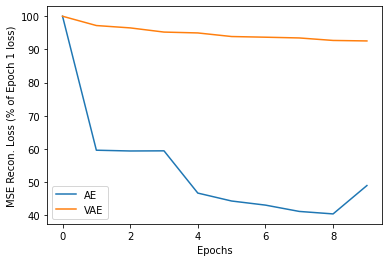

In [51]:
# Plot scaled losses
plt.plot(range(10), loss_ae/(.01*loss_ae[0]), label='AE')
plt.plot(range(10), vae_mse/(.01*vae_mse[0]), label='VAE')
plt.xlabel('Epochs')
plt.ylabel('MSE Recon. Loss (% of Epoch 1 loss)')
plt.legend()

***